In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from operator import itemgetter
import xgboost as xgb
import random
import time
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import datetime as dt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))



    
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()


def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

def get_features(train, test):
    trainval = list(train.columns.values)
    output = trainval
    return sorted(output)


def run_single(features, X_train, X_valid, y_train, y_valid, target, random_state=0):
    eta = 0.1
    max_depth= 6 
    subsample = 1
    colsample_bytree = 1
    min_chil_weight=1
    start_time = time.time()

    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "eta": eta,
        "tree_method": 'exact',
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "min_chil_weight":min_chil_weight,
        "seed": random_state,
        #"num_class" : 22,
    }
    num_boost_round = 500
    early_stopping_rounds = 20
    test_size = 0.1

   
    
    
    dtrain = xgb.DMatrix(X_train[features], y_train, missing=-99) #
    dvalid = xgb.DMatrix(X_valid[features], y_valid, missing =-99) #

    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    print("Validating...")
    check = gbm.predict(xgb.DMatrix(X_valid[features]), ntree_limit=gbm.best_iteration+1)
    
    #area under the precision-recall curve
    print(y_valid.values)
    score = average_precision_score(y_valid.values, check)
    print('area under the precision-recall curve: {:.6f}'.format(score))

    
    check2=check.round()
    score = precision_score(y_valid.values, check2)
    print('precision score: {:.6f}'.format(score))

    score = recall_score(y_valid.values, check2)
    print('recall score: {:.6f}'.format(score))
    
    imp = get_importance(gbm, features)
    print('Importance array: ', imp)

    print("Predict test set... ")
    test_prediction = gbm.predict(xgb.DMatrix(test[features]), ntree_limit=gbm.best_iteration+1)
    score = average_precision_score(y_valid.values, test_prediction)

    print('area under the precision-recall curve test set: {:.6f}'.format(score))
    
    ############################################ ROC Curve
    

 
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_valid.values, check)
    roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    ##################################################


    print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))
    return test_prediction, imp, gbm.best_iteration+1




capacity-scheduler.xml
core-site.xml
hadoop-policy.xml
hdfs-site.xml
httpfs-site.xml
kms-acls.xml
kms-site.xml
yarn-site.xml



In [4]:
# Any results you write to the current directory are saved as output.
start_time = dt.datetime.now()
print("Start time: ",start_time)
    
Spectrum=pd.read_csv('Spectrum_baseline.csv')
Spectrum.fillna(method='ffill', inplace = True)
Spectrum.fillna(value=0.0, inplace = True)
feature = Spectrum.columns
target = pd.read_csv('Spectrum_labels_binary.csv')
data = Spectrum[feature[1:]]
print(len(data), len(target))
target.head()

Start time:  2019-06-03 10:59:08.824267
11442 11442


,labels
0,0
1,0
2,0
3,0
4,0


In [5]:
ind1 = target.index[target['labels'] ==1].tolist()
ind0 = target.index[target['labels'] ==0].tolist()
train_0 = data.loc[ind0]
train_1 = data.loc[ind1]
y_0 = target.loc[ind0]
y_1 = target.loc[ind1]

In [6]:
# brute force equal distribution in train and test set
#train, test = train_test_split(data, test_size=.3, random_state=random.seed(2016))
number_train0 = int(len(train_0)*0.8)
number_train1 = int(len(train_1)*0.8)
train = pd.concat([train_0[:number_train0],train_1[:number_train1]],axis=0)
test = pd.concat([train_0[number_train0:],train_1[number_train1:]],axis=0)
y_train = pd.concat([y_0[:number_train0],y_1[:number_train1]],axis=0)
y_test = pd.concat([y_0[number_train0:],y_1[number_train1:]],axis=0)

In [7]:
print(train.shape, y_train.shape)
print(test.shape, y_test.shape)

(9153, 1015) (9153, 1)
(2289, 1015) (2289, 1)


Building model..  0:00:04.424405
XGBoost params. ETA: 0.1, MAX_DEPTH: 6, SUBSAMPLE: 1, COLSAMPLE_BY_TREE: 1
[0]	train-auc:0.943739	eval-auc:0.903882
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 20 rounds.
[1]	train-auc:0.954833	eval-auc:0.9109
[2]	train-auc:0.96247	eval-auc:0.920535
[3]	train-auc:0.967906	eval-auc:0.920557
[4]	train-auc:0.971644	eval-auc:0.922728
[5]	train-auc:0.974281	eval-auc:0.922969
[6]	train-auc:0.975803	eval-auc:0.92369
[7]	train-auc:0.976991	eval-auc:0.924099
[8]	train-auc:0.977801	eval-auc:0.925828
[9]	train-auc:0.979583	eval-auc:0.926581
[10]	train-auc:0.981201	eval-auc:0.937208
[11]	train-auc:0.982958	eval-auc:0.939346
[12]	train-auc:0.983431	eval-auc:0.939194
[13]	train-auc:0.984044	eval-auc:0.938679
[14]	train-auc:0.98484	eval-auc:0.94022
[15]	train-auc:0.986781	eval-auc:0.940496
[16]	train-auc:0.987339	eval-auc:0.940998
[17]	train-auc:0.987873	eval-auc:0.94308
[18]	train-a

[201]	train-auc:1	eval-auc:0.966976
[202]	train-auc:1	eval-auc:0.96715
[203]	train-auc:1	eval-auc:0.96713
[204]	train-auc:1	eval-auc:0.967226
[205]	train-auc:1	eval-auc:0.967282
[206]	train-auc:1	eval-auc:0.967417
[207]	train-auc:1	eval-auc:0.96748
[208]	train-auc:1	eval-auc:0.967604
[209]	train-auc:1	eval-auc:0.967595
[210]	train-auc:1	eval-auc:0.967562
[211]	train-auc:1	eval-auc:0.967678
[212]	train-auc:1	eval-auc:0.967576
[213]	train-auc:1	eval-auc:0.967437
[214]	train-auc:1	eval-auc:0.967384
[215]	train-auc:1	eval-auc:0.967467
[216]	train-auc:1	eval-auc:0.967454
[217]	train-auc:1	eval-auc:0.967515
[218]	train-auc:1	eval-auc:0.96754
[219]	train-auc:1	eval-auc:0.9675
[220]	train-auc:1	eval-auc:0.967488
[221]	train-auc:1	eval-auc:0.967488
[222]	train-auc:1	eval-auc:0.967568
[223]	train-auc:1	eval-auc:0.967585
[224]	train-auc:1	eval-auc:0.967794
[225]	train-auc:1	eval-auc:0.967908
[226]	train-auc:1	eval-auc:0.968029
[227]	train-auc:1	eval-auc:0.968053
[228]	train-auc:1	eval-auc:0.96807

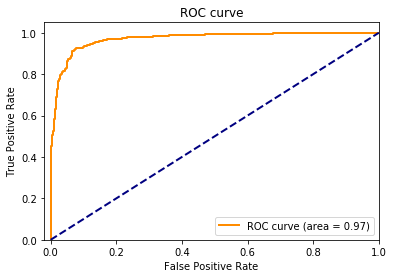

Training time: 3.37 minutes


In [8]:
print("Building model.. ",dt.datetime.now()-start_time)
features = list(train.columns.values)
preds, imp, num_boost_rounds = run_single(features[:-1],train, test,y_train, y_test, 'labels',42)